In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

<Axes: xlabel='Date'>

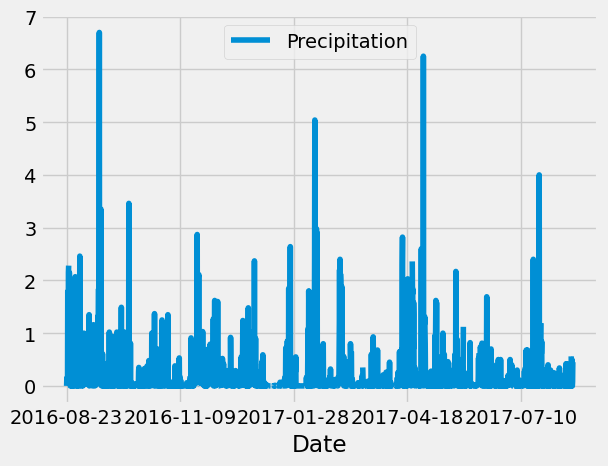

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_df.set_index(precip_df['Date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x_compat=True)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print(f"The lowest temperature at {most_active} is {lowest_temp}")
print(f"The highest temperature at {most_active} is {highest_temp}")
print(f"The average temperature at {most_active} is {avg_temp}")


The lowest temperature at USC00519281 is [(54.0,)]
The highest temperature at USC00519281 is [(85.0,)]
The average temperature at USC00519281 is [(71.66378066378067,)]


<Axes: ylabel='Frequency'>

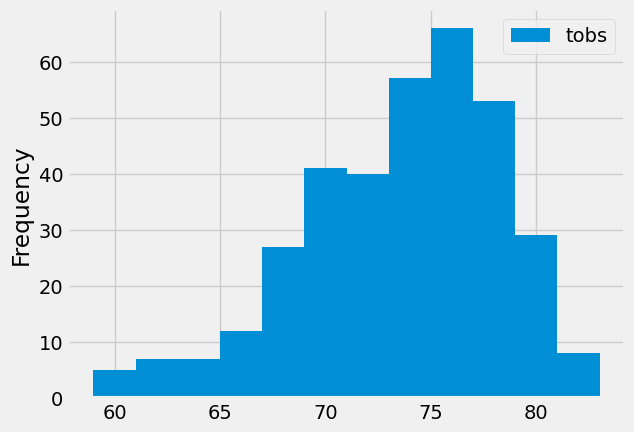

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_data, columns=['tobs'])
temp_df.plot.hist(bins=12)

# Close Session

In [16]:
# Close Session
session.close()